# Carga y preparación de datos

### Importamos librerías

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [5]:
# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

In [6]:
# Definir características
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']

In [7]:
# Separar características y objetivo
X = df[cat_cols + num_cols]
y = df['stroke']

In [8]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Crear pipelines para preprocesamiento
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [10]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

In [12]:
# Preparar los datos
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

# Modelos de predicción de accidentes cerebrovasculares

## Implementación de modelos, ROC, validación cruzada y optimización de hiperparámetros

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import optuna

/Users/cash/Desktop/F5/Python/DataScience/data-scientist-grupo4/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Función para entrenar y evaluar modelos
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    return auc, cv_scores.mean(), cv_scores.std()

In [16]:
# Lista de modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [17]:
# Entrenar y evaluar modelos
results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    auc, cv_mean, cv_std = train_evaluate_model(model, X_train_prepared, y_train, X_test_prepared, y_test)
    results[name] = {'AUC': auc, 'CV Mean': cv_mean, 'CV Std': cv_std}
    print(f"{name}: AUC = {auc:.4f}, CV Mean = {cv_mean:.4f} ± {cv_std:.4f}")
    
    if auc > best_auc:
        best_auc = auc
        best_model = (name, model)

print(f"\nBest model: {best_model[0]} with AUC = {best_auc:.4f}")

Logistic Regression: AUC = 0.8490, CV Mean = 0.8349 ± 0.0249
Random Forest: AUC = 0.8057, CV Mean = 0.7840 ± 0.0332
[LightGBM] [Info] Number of positive: 194, number of negative: 3790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 3984, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048695 -> initscore=-2.972263
[LightGBM] [Info] Start training from score -2.972263
[LightGBM] [Info] Number of positive: 155, number of negative: 3032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641
[LightGBM] [Info] Number of data points in the train set: 3187, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore

# Resumen de los resultados:

### Logistic Regression:
AUC: 0.8490

Media de validación cruzada (CV Mean): 0.8349 ± 0.0249

**Resultado**: Mejor modelo en términos de AUC, lo que indica un mejor rendimiento en la clasificación de las clases positivas y negativas.

### Random Forest:
AUC: 0.8057

CV Mean: 0.7840 ± 0.0332

**Resultado**: Tiene un rendimiento inferior tanto en AUC como en validación cruzada en comparación con la regresión logística.

### LightGBM:
AUC: 0.8210

CV Mean: 0.8022 ± 0.0173

**Resultado**: Mejor que Random Forest, pero inferior a Logistic Regression.

### XGBoost:
AUC: 0.7998

CV Mean: 0.7948 ± 0.0185

**Resultado**: Similar a Random Forest, pero con un AUC ligeramente inferior.

### CatBoost:
AUC: 0.8187

CV Mean: 0.8028 ± 0.0159

**Resultado**: Similar a LightGBM, con una leve ventaja en CV Mean.

**Conclusión**:
Mejor modelo: Logistic Regression con un AUC de 0.8490 y una buena estabilidad (CV Mean = 0.8349 ± 0.0249), lo que sugiere que es el más adecuado para este problema de clasificación, superando en rendimiento a los modelos de bosque aleatorio (Random Forest) y de boosting (LightGBM, XGBoost, CatBoost).

In [19]:
# Optimización de hiperparámetros con Optuna
def objective(trial):
    if best_model[0] == 'Logistic Regression':
        model = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e5),
            solver=trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
        )
    elif best_model[0] == 'Random Forest':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 1000),
            max_depth=trial.suggest_int('max_depth', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
        )
    elif best_model[0] == 'LightGBM':
        model = LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 2, 256),
            max_depth=trial.suggest_int('max_depth', 3, 16),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000)
        )
    elif best_model[0] == 'XGBoost':
        model = XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 9),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 300)
        )
    else:  # CatBoost
        model = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 1000),
            depth=trial.suggest_int('depth', 4, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            l2_leaf_reg=trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
            verbose=0
        )
    
    return -cross_val_score(model, X_train_prepared, y_train, cv=5, scoring='roc_auc').mean()

In [21]:
# Importar la libreria warnings para ocultar los mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-10-10 20:23:03,653] A new study created in memory with name: no-name-a902a5e3-21a9-4a91-9a3a-30c8d43a0fc8
[I 2024-10-10 20:23:03,731] Trial 0 finished with value: -0.8348370418638437 and parameters: {'C': 50.98897595258367, 'solver': 'liblinear'}. Best is trial 0 with value: -0.8348370418638437.
[I 2024-10-10 20:23:03,790] Trial 1 finished with value: -0.8160048996043997 and parameters: {'C': 0.0001170582712252737, 'solver': 'lbfgs'}. Best is trial 0 with value: -0.8348370418638437.
[I 2024-10-10 20:23:03,860] Trial 2 finished with value: -0.8348368638258931 and parameters: {'C': 7580.842757377105, 'solver': 'liblinear'}. Best is trial 0 with value: -0.8348370418638437.
[I 2024-10-10 20:23:03,947] Trial 3 finished with value: -0.8351633854272377 and parameters: {'C': 0.37913753946017503, 'solver': 'lbfgs'}. Best is trial 3 with value: -0.8351633854272377.
[I 2024-10-10 20:23:04,020] Trial 4 finished with value: -0.8348368638258931 and parameters: {'C': 463.87779787261974, 'solv

In [22]:
# Entrenar el mejor modelo con los mejores hiperparámetros
best_params = study.best_params
best_model_optimized = models[best_model[0]]
best_model_optimized.set_params(**best_params)
best_model_optimized.fit(X_train_prepared, y_train)

LogisticRegression(C=0.10366534379347432, solver='liblinear')

El ** en Python descomprime un diccionario en clave-valor como argumentos de una función. Aquí, best_params es un diccionario que contiene los mejores hiperparámetros que Optuna ha encontrado, y set_params es una función que asigna esos valores al modelo.

In [23]:
# Evaluar el modelo optimizado
y_pred_proba_optimized = best_model_optimized.predict_proba(X_test_prepared)[:, 1]
auc_optimized = roc_auc_score(y_test, y_pred_proba_optimized)
print(f"\nBest model after optimization: {best_model[0]}")
print(f"Best parameters: {best_params}")
print(f"AUC after optimization: {auc_optimized:.4f}")


Best model after optimization: Logistic Regression
Best parameters: {'C': 0.10366534379347432, 'solver': 'liblinear'}
AUC after optimization: 0.8493


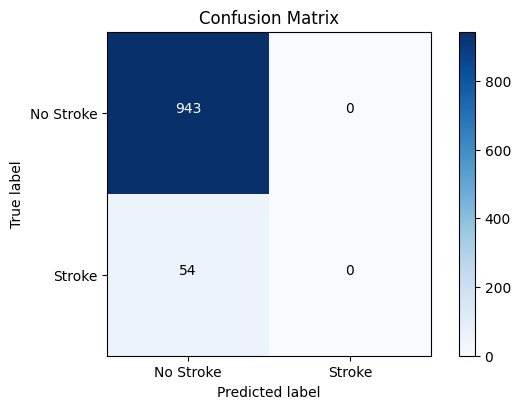

In [26]:
# Visualizar matriz de confusión
y_pred_optimized = best_model_optimized.predict(X_test_prepared)
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

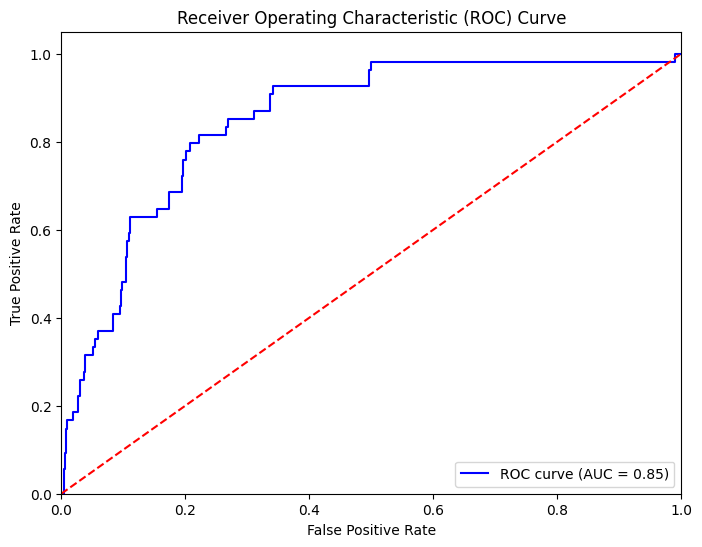

In [27]:
# Visualizar curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_optimized)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc_optimized:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()